Example asymmetry bin uncertainty: 0.01597555004554079


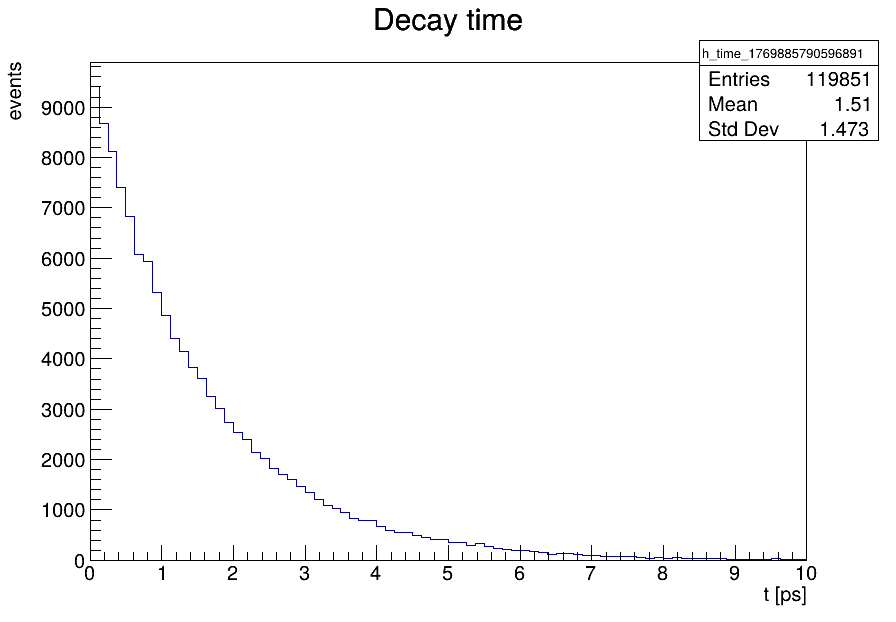

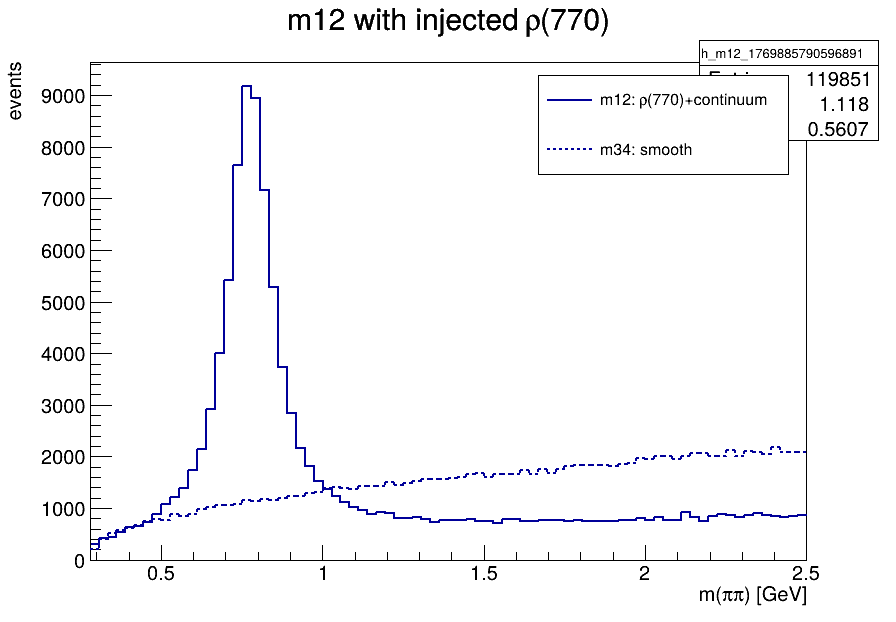

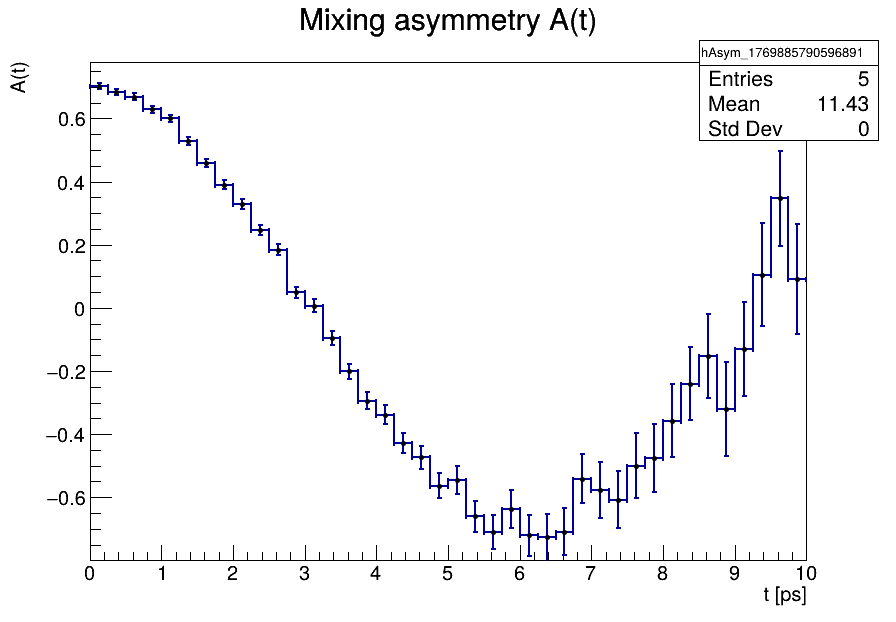

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Info in <TCanvas::Print>: png file inline_plots/time_1769885790596891.png has been created
Info in <TCanvas::Print>: png file inline_plots/mass_1769885790596891.png has been created
Info in <TCanvas::Print>: png file inline_plots/asym_1769885790596891.png has been created


In [2]:
# ============================================================
# Cell 1 : toy B0 mixing + resonance + asymmetry (with visible central curve)
#
# Produces 3 inline plots:
#   1) Exponential decay-time distribution
#   2) m12 with an injected ρ(770) peak, overlaid with smooth m34
#   3) Mixing asymmetry A(t) with BOTH:
#        - a central step-curve (bin contents)
#        - error bars (statistical uncertainties)
# ============================================================

import math, random, os, time
import ROOT
from IPython.display import Image, display

ROOT.gROOT.SetBatch(True)
os.makedirs("inline_plots", exist_ok=True)

RUN_ID = str(int(time.time() * 1e6))

# -----------------------------
# Parameters
# -----------------------------
N_EVENTS = 120_000

TAU_B0_PS = 1.52
T_MAX_PS  = 10.0

DELTA_M_PS_INV = 0.51
OSC_AMPLITUDE  = 0.7

PION_MASS_GEV = 0.13957
RHO_MASS_GEV  = 0.77526
RHO_WIDTH_GEV = 0.1491
RHO_FRACTION_IN_M12 = 0.60

M_MIN_GEV = 2.0 * PION_MASS_GEV
M_MAX_GEV = 2.5

# -----------------------------
# Sampling helpers
# -----------------------------
def sample_decay_time(tau_ps):
    # Exponential decay: p(t) = (1/τ) exp(-t/τ)
    u = random.random()
    return -tau_ps * math.log(1.0 - u)

def smooth_mass(lo, hi):
    u = random.random()
    return lo + (hi - lo) * (u**0.7)

def breit_wigner(m0, gamma, lo, hi):
    # BW(m) ∝ 1 / [ (m-m0)^2 + (Γ/2)^2 ]
    peak = 1.0 / ((gamma/2.0)**2)
    while True:
        m = random.uniform(lo, hi)
        bw = 1.0 / (((m - m0)**2) + (gamma/2.0)**2)
        if random.random() < bw / peak:
            return m

# -----------------------------
# Histograms
# -----------------------------
h_time = ROOT.TH1F(f"h_time_{RUN_ID}", "Decay time; t [ps]; events", 80, 0.0, T_MAX_PS)
h_m12  = ROOT.TH1F(f"h_m12_{RUN_ID}",  "m12 with injected #rho(770); m(#pi#pi) [GeV]; events", 80, M_MIN_GEV, M_MAX_GEV)
h_m34  = ROOT.TH1F(f"h_m34_{RUN_ID}",  "m34 smooth continuum; m(#pi#pi) [GeV]; events", 80, M_MIN_GEV, M_MAX_GEV)

NBINS_ASYM = 40
hB0    = ROOT.TH1F(f"hB0_{RUN_ID}",    "B^{0} counts; t [ps]; events", NBINS_ASYM, 0.0, T_MAX_PS)
hB0bar = ROOT.TH1F(f"hB0bar_{RUN_ID}", "#bar{B}^{0} counts; t [ps]; events", NBINS_ASYM, 0.0, T_MAX_PS)

for h in (h_time, h_m12, h_m34, hB0, hB0bar):
    h.SetDirectory(0)

# Enable proper Poisson uncertainties on counts
hB0.Sumw2()
hB0bar.Sumw2()

# -----------------------------
# Generate events
# -----------------------------
for _ in range(N_EVENTS):

    t = sample_decay_time(TAU_B0_PS)
    if t > T_MAX_PS:
        continue
    h_time.Fill(t)

    # Resonance injection in m12
    if random.random() < RHO_FRACTION_IN_M12:
        m12 = breit_wigner(RHO_MASS_GEV, RHO_WIDTH_GEV, M_MIN_GEV, M_MAX_GEV)
    else:
        m12 = smooth_mass(M_MIN_GEV, M_MAX_GEV)

    m34 = smooth_mass(M_MIN_GEV, M_MAX_GEV)

    h_m12.Fill(m12)
    h_m34.Fill(m34)

    # Mixing probability:
    #   P(B0|t) = 1/2 [1 + A cos(Δm t)]
    p_B0 = 0.5 * (1.0 + OSC_AMPLITUDE * math.cos(DELTA_M_PS_INV * t))
    p_B0 = max(0.0, min(1.0, p_B0))

    if random.random() < p_B0:
        hB0.Fill(t)
    else:
        hB0bar.Fill(t)

# -----------------------------
# Asymmetry with propagated errors
#   A(t) = (N(B0)-N(B0bar)) / (N(B0)+N(B0bar))
# -----------------------------
hSum = hB0.Clone(f"hSum_{RUN_ID}")
hSum.SetDirectory(0)
hSum.Sumw2()
hSum.Add(hB0bar)

hDiff = hB0.Clone(f"hDiff_{RUN_ID}")
hDiff.SetDirectory(0)
hDiff.Sumw2()
hDiff.Add(hB0bar, -1)

hAsym = hDiff.Clone(f"hAsym_{RUN_ID}")
hAsym.SetDirectory(0)
hAsym.Sumw2()
hAsym.Divide(hSum)
hAsym.SetTitle("Mixing asymmetry A(t); t [ps]; A(t)")

# Quick bin-error check (should not be zero)
print("Example asymmetry bin uncertainty:",
      hAsym.GetBinError(10))

# -----------------------------
# Plot 1: decay time
# -----------------------------
c1 = ROOT.TCanvas(f"c1_{RUN_ID}", "", 900, 650)
h_time.Draw("hist")
p1 = f"inline_plots/time_{RUN_ID}.png"
c1.SaveAs(p1)
display(Image(p1))

# -----------------------------
# Plot 2: mass overlay
# -----------------------------
c2 = ROOT.TCanvas(f"c2_{RUN_ID}", "", 900, 650)
h_m12.SetLineWidth(2)
h_m34.SetLineWidth(2)
h_m34.SetLineStyle(2)

h_m12.Draw("hist")
h_m34.Draw("hist same")

leg = ROOT.TLegend(0.60, 0.72, 0.88, 0.88)
leg.SetTextSize(0.028)
leg.AddEntry(h_m12, "m12: #rho(770)+continuum", "l")
leg.AddEntry(h_m34, "m34: smooth", "l")
leg.Draw()

p2 = f"inline_plots/mass_{RUN_ID}.png"
c2.SaveAs(p2)
display(Image(p2))

# -----------------------------
# Plot 3: asymmetry with central curve + error bars
# -----------------------------
c3 = ROOT.TCanvas(f"c3_{RUN_ID}", "", 900, 650)

# Draw central values as a visible step-line
hAsym.SetLineWidth(2)
hAsym.Draw("HIST")

# Overlay error bars + markers
hAsym.SetMarkerStyle(20)
hAsym.SetMarkerSize(0.7)
hAsym.Draw("E1 SAME")

p3 = f"inline_plots/asym_{RUN_ID}.png"
c3.SaveAs(p3)
display(Image(p3))


Example bin error (should be > 0): 0.01597555004554079


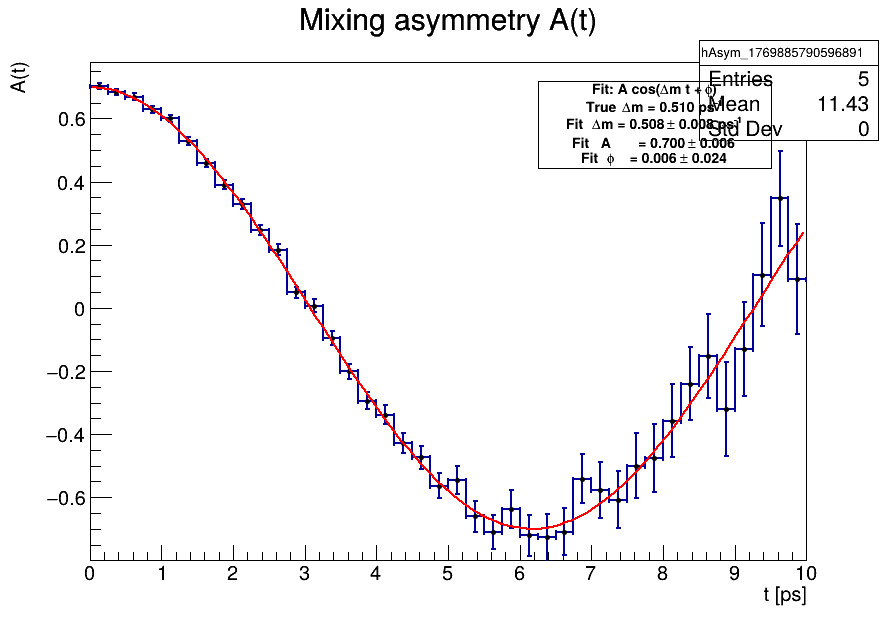

True Δm  = 0.510000 1/ps
Fit  Δm  = 0.507711 ± 0.007902 1/ps
Fit  A   = 0.700163 ± 0.006333
Fit  phi = 0.006387 ± 0.024229


Info in <TCanvas::Print>: png file inline_plots/fit_delta_m_1769886503890893.png has been created


In [5]:
# ============================================================
# Cell 2: fit the mixing asymmetry to extract Δm (with real uncertainties)
# ============================================================
# The asymmetry A(t) oscillates because neutral B mesons mix:
#
#   B0  ↔  B0bar
#
# In the toy generator, the probability that an event is tagged as B0 at decay time t was
#
#   P(B0 | t) = 1/2 [ 1 + A cos(Δm t) ] ,
#
# where Δm is the B0–B0bar oscillation frequency.  
# This immediately leads to an expected asymmetry of the form
#
#   A(t) ≈ A cos(Δm t).
#
# Fitting this oscillatory curve allows Δm to be extracted directly from the time
# dependence of the tagged sample.
#
# The fit is performed using the bin-by-bin statistical uncertainties on A(t).
# ROOT only gives meaningful parameter errors if the fit is weighted by these σ_A(t),
# which is why the "E" option (use errors) is important.
#
# The result is the fitted oscillation frequency Δm, with an uncertainty, shown as an
# overlaid curve on top of the measured asymmetry points.
#
# In a full CP violation analysis, this structure is extended to include both sine and
# cosine terms:
#
#   A(t) = S sin(Δm t) − C cos(Δm t),
#
# where S and C encode CP-violating effects.


import time, ROOT, math
from IPython.display import Image, display

ROOT.gROOT.SetBatch(True)

# Unique names to avoid ROOT collisions if you re-run this cell
RUN_ID = str(int(time.time() * 1e6))

# -----------------------------
# Basic sanity checks
# -----------------------------
# hAsym should exist from Cell 1
try:
    _ = hAsym.GetNbinsX()
except NameError:
    raise RuntimeError("hAsym not found. Run Cell 1 first (the generation/asymmetry cell).")

# Confirm errors are non-zero (if errors are all zero, fit uncertainties will be nonsense)
example_err = hAsym.GetBinError(10)
print("Example bin error (should be > 0):", example_err)

# -----------------------------
# Fit model: A_fit * cos(Δm_fit * t + phi_fit)
# -----------------------------
# We allow a phase phi to absorb small distortions and make the fit more stable.
fit_func = ROOT.TF1(f"fit_cos_{RUN_ID}", "[0]*cos([1]*x + [2])", 0.0, T_MAX_PS)
fit_func.SetParName(0, "A_fit")
fit_func.SetParName(1, "Delta_m_fit")
fit_func.SetParName(2, "phi_fit")

# Initial guesses (help ROOT converge)
fit_func.SetParameter(0, 0.6)               # amplitude guess
fit_func.SetParameter(1, 0.5)               # Δm guess (close to 0.51)
fit_func.SetParameter(2, 0.0)               # phase guess

# Optional: constrain parameters to sensible ranges to prevent wild fits
fit_func.SetParLimits(0, 0.0,  1.0)          # amplitude between 0 and 1 (toy)
fit_func.SetParLimits(1, 0.0,  5.0)          # Δm positive
fit_func.SetParLimits(2, -math.pi, math.pi)  # phase wrapped

# -----------------------------
# Perform the fit
# -----------------------------
# Fit options:
#   Q = quiet
#   R = use function range
#   E = use bin errors (crucial!)
#   S = return fit result (useful for diagnostics)
#
# We also use "0" to not auto-draw during Fit.
fit_result = hAsym.Fit(fit_func, "QRES0")

# Extract fitted values and uncertainties
A_fit   = fit_func.GetParameter(0)
dm_fit  = fit_func.GetParameter(1)
phi_fit = fit_func.GetParameter(2)

A_err   = fit_func.GetParError(0)
dm_err  = fit_func.GetParError(1)
phi_err = fit_func.GetParError(2)

# -----------------------------
# Plot asymmetry: central curve + error bars + fit curve
# -----------------------------
c = ROOT.TCanvas(f"c_fit_{RUN_ID}", "", 900, 650)

# Draw the binned central values as a step-line
hAsym.SetLineWidth(2)
hAsym.Draw("HIST")

# Overlay points with error bars (so the fit weighting is visually clear)
hAsym.SetMarkerStyle(20)
hAsym.SetMarkerSize(0.7)
hAsym.Draw("E1 SAME")

# Overlay fitted function
fit_func.SetLineWidth(2)
fit_func.Draw("SAME")

# Small result box (not huge)
pt = ROOT.TPaveText(0.60, 0.73, 0.86, 0.87, "NDC")
pt.SetFillStyle(0)
pt.SetBorderSize(1)
pt.SetTextSize(0.024)

pt.AddText("Fit: A cos(#Deltam t + #phi)")
pt.AddText(f"True  #Deltam = {DELTA_M_PS_INV:.3f} ps^{{-1}}")
pt.AddText(f"Fit   #Deltam = {dm_fit:.3f} #pm {dm_err:.3f} ps^{{-1}}")
pt.AddText(f"Fit   A       = {A_fit:.3f} #pm {A_err:.3f}")
pt.AddText(f"Fit   #phi    = {phi_fit:.3f} #pm {phi_err:.3f}")
pt.Draw()

png_path = f"inline_plots/fit_delta_m_{RUN_ID}.png"
c.SaveAs(png_path)
display(Image(png_path))

print(f"True Δm  = {DELTA_M_PS_INV:.6f} 1/ps")
print(f"Fit  Δm  = {dm_fit:.6f} ± {dm_err:.6f} 1/ps")
print(f"Fit  A   = {A_fit:.6f} ± {A_err:.6f}")
print(f"Fit  phi = {phi_fit:.6f} ± {phi_err:.6f}")


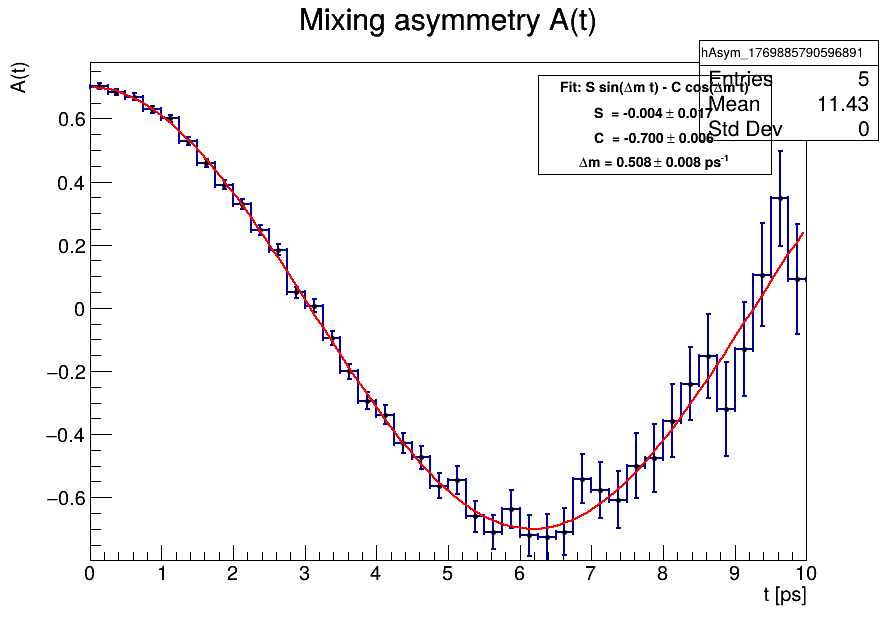

S  = -0.004474 ± 0.016990
C  = -0.700148 ± 0.006253
Δm = 0.507710 ± 0.007900 1/ps


Info in <TCanvas::Print>: png file inline_plots/fit_S_C_1769886866436788.png has been created


In [6]:
# The next step is to allow for CP-violating effects in the time-dependent asymmetry.
#
# Mixing alone produces a cosine oscillation, but when CP violation is present the most
# general form becomes
#
#   A(t) = S sin(Δm t) − C cos(Δm t).
#
# Here:
#   • C measures “direct” CP violation: an imbalance at t = 0.
#   • S measures “mixing-induced” CP violation: interference between mixing and decay.
#
# Fitting the asymmetry histogram to this sine–cosine form gives estimates of S and C,
# with uncertainties set by the bin-by-bin statistical errors on A(t).
#
# The plot overlays the fitted curve on the measured asymmetry points to show whether
# the oscillation pattern is being captured.

import time, ROOT, math
from IPython.display import Image, display

ROOT.gROOT.SetBatch(True)
RUN_ID = str(int(time.time() * 1e6))

# hAsym should already exist from the generation cell
try:
    _ = hAsym.GetNbinsX()
except NameError:
    raise RuntimeError("hAsym not found. Run the generation/asymmetry cell first.")

# Use Δm from the previous fit if available; otherwise fall back to the generator value
try:
    dm_seed = float(dm_fit)
except Exception:
    dm_seed = float(DELTA_M_PS_INV)

# Model:
#   A(t) = S sin(Δm t) − C cos(Δm t)
#
# Parameters:
#   [0] = S
#   [1] = C
#   [2] = Δm
fit_sc = ROOT.TF1(f"fit_sc_{RUN_ID}", "[0]*sin([2]*x) - [1]*cos([2]*x)", 0.0, T_MAX_PS)
fit_sc.SetParName(0, "S")
fit_sc.SetParName(1, "C")
fit_sc.SetParName(2, "Delta_m")

# Starting guesses help convergence
fit_sc.SetParameter(0, 0.0)      # S guess
fit_sc.SetParameter(1, 0.3)      # C guess
fit_sc.SetParameter(2, dm_seed)  # Δm guess

# Reasonable limits (toy-level)
fit_sc.SetParLimits(0, -1.0, 1.0)
fit_sc.SetParLimits(1, -1.0, 1.0)
fit_sc.SetParLimits(2,  0.0, 5.0)

# Fit with error weighting ("E") so uncertainties are meaningful
hAsym.Fit(fit_sc, "QRES0")

S_fit  = fit_sc.GetParameter(0)
C_fit  = fit_sc.GetParameter(1)
dm_fit2 = fit_sc.GetParameter(2)

S_err  = fit_sc.GetParError(0)
C_err  = fit_sc.GetParError(1)
dm_err2 = fit_sc.GetParError(2)

# Plot: central curve + error bars + fitted function
c = ROOT.TCanvas(f"c_sc_{RUN_ID}", "", 900, 650)

hAsym.SetLineWidth(2)
hAsym.Draw("HIST")

hAsym.SetMarkerStyle(20)
hAsym.SetMarkerSize(0.7)
hAsym.Draw("E1 SAME")

fit_sc.SetLineWidth(2)
fit_sc.Draw("SAME")

# Small results box
pt = ROOT.TPaveText(0.60, 0.72, 0.86, 0.88, "NDC")
pt.SetFillStyle(0)
pt.SetBorderSize(1)
pt.SetTextSize(0.024)
pt.AddText("Fit: S sin(#Deltam t) - C cos(#Deltam t)")
pt.AddText(f"S  = {S_fit:.3f} #pm {S_err:.3f}")
pt.AddText(f"C  = {C_fit:.3f} #pm {C_err:.3f}")
pt.AddText(f"#Deltam = {dm_fit2:.3f} #pm {dm_err2:.3f} ps^{{-1}}")
pt.Draw()

png_path = f"inline_plots/fit_S_C_{RUN_ID}.png"
c.SaveAs(png_path)
display(Image(png_path))

print(f"S  = {S_fit:.6f} ± {S_err:.6f}")
print(f"C  = {C_fit:.6f} ± {C_err:.6f}")
print(f"Δm = {dm_fit2:.6f} ± {dm_err2:.6f} 1/ps")
